# Deep Maxout Network avec entraînement classique et évaluation sur base de teste adversariale

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from maxout import CustomMaxout
from adv_attack import create_adv_test

import matplotlib.pyplot as plt
import numpy as np


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## 1. Chargement de la base de données

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)
batch_size = 64

training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## 2. Modèle de prédiction

## 4. Création des modèles utiles

On a besoin d'un modèle  à 240 unit per layer et d'un autre  à 1600

Définition des paramètres utiles à l'entrainement.

In [3]:
n_channels = 1
dropout = 0.5

#on créé le premier model qui à 240 unit per layer model
Maxout_240U_Model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28*n_channels, 240),
    CustomMaxout(240, 200, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(200, 160),
    CustomMaxout(160, 120, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(120, 80),
    CustomMaxout(80, 40, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(40, 10),
    nn.LogSoftmax(dim=1)
)

#on créé le second modèle qui a 1600 unit per layer
Maxout_1600U_Model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28*n_channels, 1600),
    CustomMaxout(1600, 1500, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(1500, 1400),
    CustomMaxout(1400, 1300, n_channels, True),
    nn.Linear(1300, 1200),
    CustomMaxout(1200, 1100, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(1100, 1000),
    CustomMaxout(1000, 800, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(800, 600),
    CustomMaxout(600, 400, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(400, 200),  
    CustomMaxout(200, 100, n_channels, True),
    nn.Dropout(dropout),
    nn.Linear(100, 50),
    CustomMaxout(50, 25, n_channels, True),  
    nn.Dropout(dropout),
    nn.Linear(25, 10),  
    nn.LogSoftmax(dim=1)
)

## 5. Entrainement du modèle 

Epoch 1/30.. Train loss: 0.784.. Train accuracy: 75.372.. 
Epoch 2/30.. Train loss: 0.620.. Train accuracy: 81.520.. 
Epoch 3/30.. Train loss: 0.595.. Train accuracy: 82.405.. 
Epoch 4/30.. Train loss: 0.580.. Train accuracy: 83.080.. 
Epoch 5/30.. Train loss: 0.572.. Train accuracy: 83.357.. 
Epoch 6/30.. Train loss: 0.567.. Train accuracy: 83.692.. 
Epoch 7/30.. Train loss: 0.556.. Train accuracy: 83.918.. 
Epoch 8/30.. Train loss: 0.554.. Train accuracy: 83.875.. 
Epoch 9/30.. Train loss: 0.548.. Train accuracy: 84.247.. 
Epoch 10/30.. Train loss: 0.539.. Train accuracy: 84.475.. 
Epoch 11/30.. Train loss: 0.535.. Train accuracy: 84.523.. 
Epoch 12/30.. Train loss: 0.533.. Train accuracy: 84.515.. 
Epoch 13/30.. Train loss: 0.524.. Train accuracy: 84.772.. 
Epoch 14/30.. Train loss: 0.523.. Train accuracy: 85.147.. 
Epoch 15/30.. Train loss: 0.521.. Train accuracy: 84.892.. 
Epoch 16/30.. Train loss: 0.520.. Train accuracy: 85.070.. 
Epoch 17/30.. Train loss: 0.523.. Train accuracy:

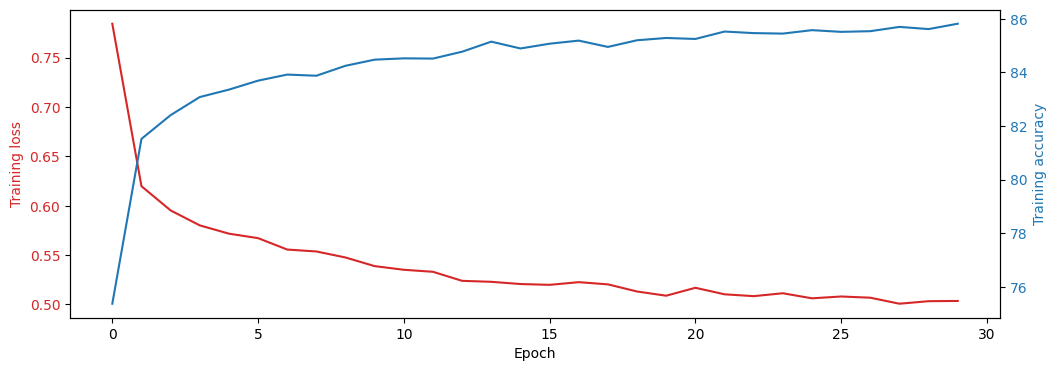

Validation loss: 0.359.. Validation accuracy: 90.110
Epoch 1/30.. Train loss: 1.736.. Train accuracy: 37.843.. 
Epoch 2/30.. Train loss: 1.328.. Train accuracy: 52.480.. 
Epoch 3/30.. Train loss: 1.176.. Train accuracy: 59.487.. 
Epoch 4/30.. Train loss: 1.162.. Train accuracy: 60.052.. 
Epoch 5/30.. Train loss: 1.177.. Train accuracy: 59.187.. 
Epoch 6/30.. Train loss: 1.137.. Train accuracy: 60.965.. 
Epoch 7/30.. Train loss: 1.131.. Train accuracy: 61.280.. 
Epoch 8/30.. Train loss: 1.121.. Train accuracy: 61.780.. 
Epoch 9/30.. Train loss: 1.149.. Train accuracy: 60.562.. 
Epoch 10/30.. Train loss: 1.143.. Train accuracy: 60.743.. 
Epoch 11/30.. Train loss: 1.137.. Train accuracy: 61.213.. 
Epoch 12/30.. Train loss: 1.140.. Train accuracy: 60.968.. 
Epoch 13/30.. Train loss: 1.151.. Train accuracy: 60.193.. 
Epoch 14/30.. Train loss: 1.157.. Train accuracy: 60.162.. 
Epoch 15/30.. Train loss: 1.141.. Train accuracy: 60.922.. 
Epoch 16/30.. Train loss: 1.163.. Train accuracy: 59.717

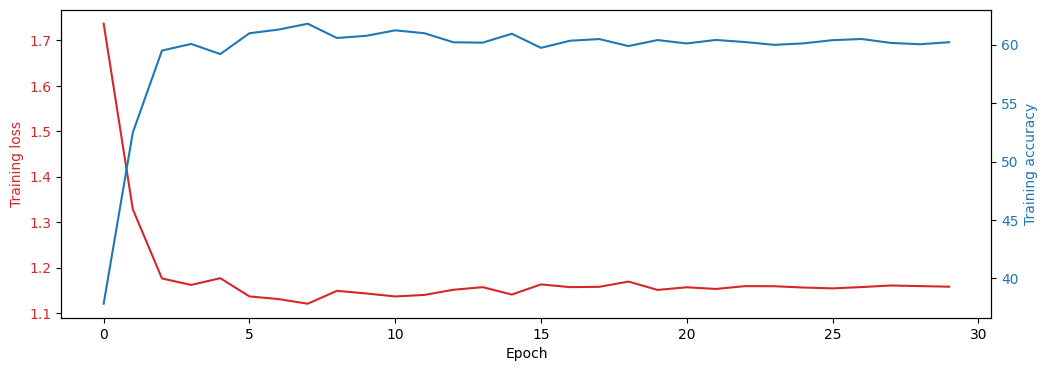

Validation loss: 0.829.. Validation accuracy: 72.520


In [4]:
# Initialize the early stopping variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stop_epochs = 10  


# Define the model
model_dict = {"Maxout_240U_Model": Maxout_240U_Model, "Maxout_1600U_Model": Maxout_1600U_Model}

for model_name, model in model_dict.items():
    # Define the optimizer
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Define the loss function
    loss_func = nn.CrossEntropyLoss()

    # Define the number of epochs
    n_epochs = 30

    # Define the training and validation data loaders
    train_dataloader = training_dataloader
    valid_dataloader = test_dataloader

    # Train the model
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for batch in train_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataloader))
        train_accuracies.append(100 * correct_train / total_train)
        print(f'Epoch {epoch+1}/{n_epochs}.. '
              f'Train loss: {train_losses[-1]:.3f}.. '
              f'Train accuracy: {train_accuracies[-1]:.3f}.. ')

    
    # Plot the training losses and accuracies
    fig, ax1 = plt.subplots(figsize=(12, 4))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Training accuracy', color=color) 
    ax2.plot(train_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()

    model.eval()
    valid_loss = 0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)


            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            loss = loss_func(outputs, labels)

            valid_loss += loss.item()

    valid_losses.append(valid_loss / len(valid_dataloader))
    valid_accuracies.append(100 * correct_valid / total_valid)

    #early stopping
    # Check if the validation loss has improved
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # If the validation loss hasn't improved for early_stop_epochs, stop training
    if epochs_no_improve == early_stop_epochs:
        print("Early stopping!")
        break

    print(f'Validation loss of {model_name}: {valid_losses[-1]:.3f}.. '
          f'Validation accuracy of {model_name}: {valid_accuracies[-1]:.3f}')



## 6. Création set de test adversarial

In [5]:
# Get the images and labels from the test set
x_test = torch.cat([images for images, labels in test_dataloader]).to(device)  # Test images
y_test = torch.cat([labels for images, labels in test_dataloader]).to(device)  # Test labels

eps = 0.1

# Create adversarial images for the network with 240 units
altered_test_240U = create_adv_test(Maxout_240U_Model.to(device), x_test, y_test, eps, loss_func)

# Create adversarial images for the network with 1600 units
altered_test_1600U = create_adv_test(Maxout_1600U_Model.to(device), x_test, y_test, eps, loss_func)

/home/sylogue/Master 2/MLA/Adversarial_attack/scripts/adv_attack.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_im_norm =torch.tensor(alt_im, dtype=torch.float32)


## 7 . évaluation des modèles sur la nouvelle base de test adversariale

In [7]:
test_loss = 0
correct_test_preds = 0
total_test_preds = 0
misclassified_confidences = []
for model_name, model in model_dict.items():
    model.eval()  
    
    with torch.no_grad():  
        for batch in test_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            probabilities = torch.exp(outputs)  # on récupère le logsoftmax et on le passe  à l'exp
            _, predicted = torch.max(outputs.data, 1)
            total_test_preds += labels.size(0)
            correct_test_preds += (predicted == labels).sum().item()
    
            # Calculate confidence
            confidence = torch.max(probabilities, dim=1)[0]
    
            # Store confidence of misclassified examples
            misclassified = predicted != labels
            misclassified_confidences.extend(confidence[misclassified].tolist())
    
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
    
    test_accuracy = 100 * correct_test_preds / total_test_preds
    print(f'Test loss of {model_name}: {test_loss / len(test_dataloader):.3f}.. '
          f'Test accuracy of {model_name}: {test_accuracy:.3f}')
    print(f'Average confidence of misclassified examples of {model_name}: {np.mean(misclassified_confidences):.3f}')

Test loss: 0.832.. Test accuracy: 72.520
Average confidence of misclassified examples: -0.725
